In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

sns.set_theme(style="whitegrid")

In [ ]:
# Load the data files 
gene_expr_df = pd.read_excel("Gene_Expression_Data.xlsx", index_col=0)
gene_info_df = pd.read_csv("Gene_Information.csv")
sample_info_df = pd.read_csv("Sample_Information.tsv", sep='\t')

print("Gene Expression Data Head:")
display(gene_expr_df.head())
print("\nGene Information Data Head:")
display(gene_info_df.head())
print("\nSample Information Data Head:")
display(sample_info_df.head())

Gene Expression Data Head:


,GSM820516,GSM820517,GSM820518,GSM820519,GSM820520,GSM820521,GSM820522,GSM820523,GSM820524,GSM820525,GSM820526,GSM820527,GSM820528,GSM820529,GSM820530,GSM820531,GSM820532,GSM820533
Probe_ID,,,,,,,,,,,,,,,,,,
ILMN_1343291,66665.3800,69404.6700,64128.0700,68943.9700,67827.2200,71775.3000,62245.5900,69713.7000,69509.2700,68244.5900,65427.4700,68436.5200,57608.6700,69959.7700,69509.2700,70063.7700,69647.1700,70332.3400
ILMN_1343295,22040.1100,13046.3400,38678.9600,16641.8900,33719.8900,18933.2900,26170.0400,9906.9130,17166.5200,12428.9500,25297.5700,17535.6000,19749.1400,17854.2900,43670.6800,22849.0800,23725.6600,28747.0100
ILMN_1651199,226.6081,205.4483,217.2475,229.0451,226.3029,203.8710,213.4431,210.4129,229.5394,212.7384,226.1345,232.2437,208.7316,229.2948,214.4033,216.6758,195.6539,252.1502
ILMN_1651209,278.5710,253.7044,211.8002,278.0423,259.8059,265.1900,321.2587,273.4458,253.6032,310.1582,275.0126,274.9519,250.6420,255.8540,219.5752,292.4965,253.3126,237.9844
ILMN_1651210,195.4914,195.9835,175.3356,193.9065,229.5674,164.0632,244.6696,190.9813,188.1039,199.3084,220.6229,213.3975,194.7746,173.7073,185.3380,174.6898,195.3534,191.9382



Gene Information Data Head:


,Probe_ID,Symbol,Entrez_Gene_ID,Chromosome,Cytoband
0,ILMN_1343291,EEF1A1,1915.0,6,6q13c
1,ILMN_1343295,GAPDH,2597.0,12,12p13.31d
2,ILMN_1651199,LOC643334,643334.0,NaN,2q37.3b
3,ILMN_1651209,SLC35E2,9906.0,1,1p36.33a
4,ILMN_1651210,DUSP22,56940.0,NaN,6p25.3b



Sample Information Data Head:


,group,patient
GSM820516,tumor,patient: 1
GSM820517,normal,patient: 1
GSM820518,tumor,patient: 2
GSM820519,normal,patient: 2
GSM820520,tumor,patient: 3


In [ ]:
# Creating a mapping from the old sample ID to the new phenotype-based name
phenotype_counts = {'tumor': 1, 'normal': 1}
new_column_names = {}

for sample_id, row in sample_info_df.iterrows():
    phenotype = row['group']
    new_name = f"{phenotype}_{phenotype_counts[phenotype]}"
    new_column_names[sample_id] = new_name
    phenotype_counts[phenotype] += 1

renamed_gene_expr_df = gene_expr_df.rename(columns=new_column_names)

# Display the new columns
print("New Sample Names (Columns):")
print(renamed_gene_expr_df.columns)

New Sample Names (Columns):
Index(['tumor_1', 'normal_1', 'tumor_2', 'normal_2', 'tumor_3', 'normal_3',
       'tumor_4', 'normal_4', 'tumor_5', 'normal_5', 'tumor_6', 'normal_6',
       'tumor_7', 'normal_7', 'tumor_8', 'normal_8', 'tumor_9', 'normal_9'],
      dtype='object')


In [ ]:
# Filter columns based on phenotype 
tumor_df = renamed_gene_expr_df.filter(regex='^tumor_')
normal_df = renamed_gene_expr_df.filter(regex='^normal_')

print(f"Tumor data shape: {tumor_df.shape}")
print(f"Normal data shape: {normal_df.shape}")

Tumor data shape: (48803, 9)
Normal data shape: (48803, 9)


In [ ]:
# Compute the average expression for each gene 
avg_tumor_expr = tumor_df.mean(axis=1)
avg_normal_expr = normal_df.mean(axis=1)

# Calculate the fold change
fold_change = (avg_tumor_expr - avg_normal_expr) / (avg_normal_expr + 1e-9)

# Create a DataFrame to hold the results
fold_change_df = pd.DataFrame({
    'Probe_ID': fold_change.index,
    'Fold_Change': fold_change.values
})

print("Fold Change Calculation Complete. Head of the result:")
display(fold_change_df.head())

Fold Change Calculation Complete. Head of the result:


,Probe_ID,Fold_Change
0,ILMN_1343291,-0.054726
1,ILMN_1343295,0.584230
2,ILMN_1651199,-0.016977
3,ILMN_1651209,-0.048425
4,ILMN_1651210,0.077316


In [6]:
# Filter for genes with an absolute fold change greater than 5
significant_genes_df = fold_change_df[abs(fold_change_df['Fold_Change']) > 5].copy()

# Merge with the gene information DataFrame to get gene names and chromosome data
degs_df = pd.merge(significant_genes_df, gene_info_df, on='Probe_ID', how='inner')

print(f"Found {len(degs_df)} differentially expressed genes (DEGs) with |Fold Change| > 5.")

Found 45 differentially expressed genes (DEGs) with |Fold Change| > 5.


In [7]:
# Add a column to indicate the direction of change
degs_df['Expression_Status'] = np.where(
    degs_df['Fold_Change'] > 0,
    'Higher in Tumor',
    'Higher in Normal'
)

print("Final DataFrame of Differentially Expressed Genes (DEGs):")
display(degs_df.head())

Final DataFrame of Differentially Expressed Genes (DEGs):


,Probe_ID,Fold_Change,Symbol,Entrez_Gene_ID,Chromosome,Cytoband,Expression_Status
0,ILMN_1651354,5.453412,SPP1,6696.0,4,4q22.1b,Higher in Tumor
1,ILMN_1655915,8.238199,MMP11,4320.0,22,22q11.23a,Higher in Tumor
2,ILMN_1666733,10.479637,IL8,3576.0,4,4q13.3d,Higher in Tumor
3,ILMN_1669046,29.304799,FOXQ1,94234.0,6,6p25.3a,Higher in Tumor
4,ILMN_1681260,6.484814,LOC643272,643272.0,3,NaN,Higher in Tumor


C:\Users\kakum\AppData\Local\Temp\ipykernel_30424\3433018887.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


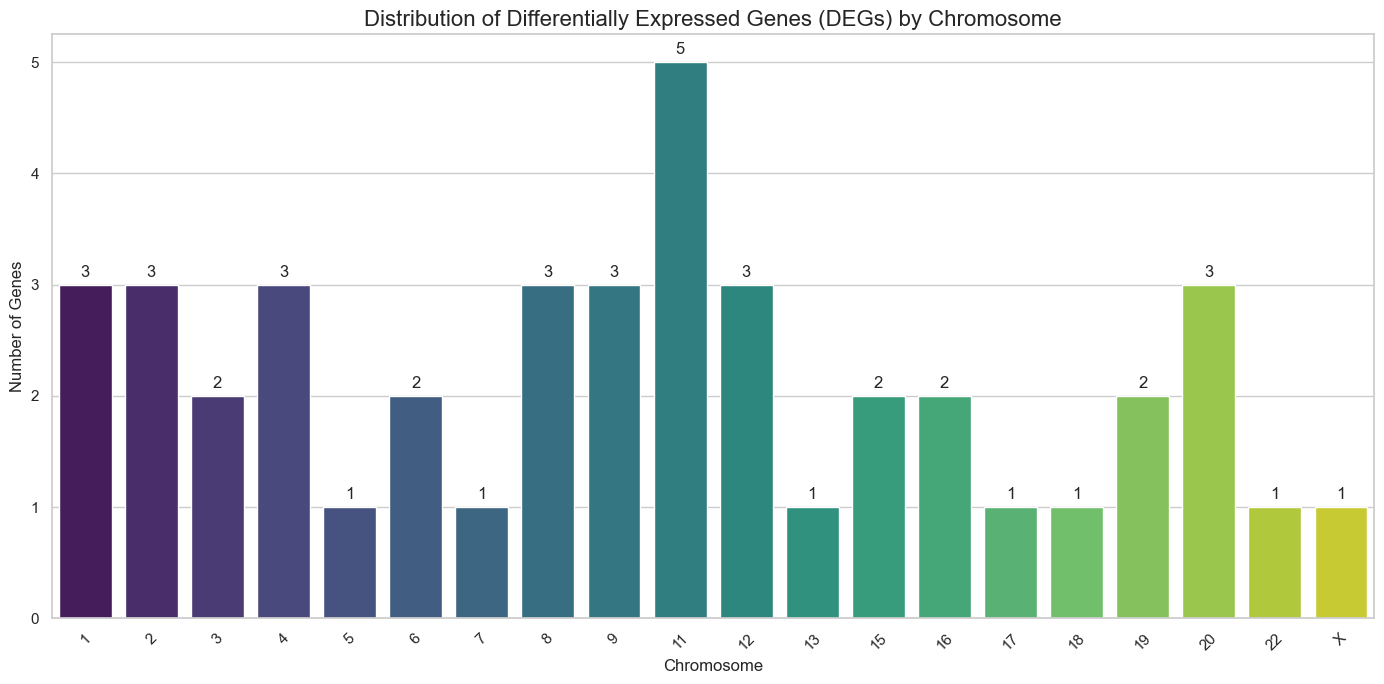

In [ ]:
plt.figure(figsize=(14, 7))

# Get a clean list of unique chromosome names
chromosomes = [c for c in degs_df['Chromosome'].unique() if pd.notna(c)]

def chromosome_sort_key(chrom):
    chrom = str(chrom) 
    if chrom.isdigit():
        return int(chrom)
    elif chrom.upper() == 'X':
        return 23
    elif chrom.upper() == 'Y':
        return 24
    else:
        return 25 

# Apply the custom sorting key
sorted_chromosomes = sorted(chromosomes, key=chromosome_sort_key)

# Create the count plot 
ax = sns.countplot(
    data=degs_df,
    x='Chromosome',
    order=sorted_chromosomes, 
    palette='viridis'
)

# Add titles and labels for clarity
ax.set_title('Distribution of Differentially Expressed Genes (DEGs) by Chromosome', fontsize=16)
ax.set_xlabel('Chromosome', fontsize=12)
ax.set_ylabel('Number of Genes', fontsize=12)

# Add value labels on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

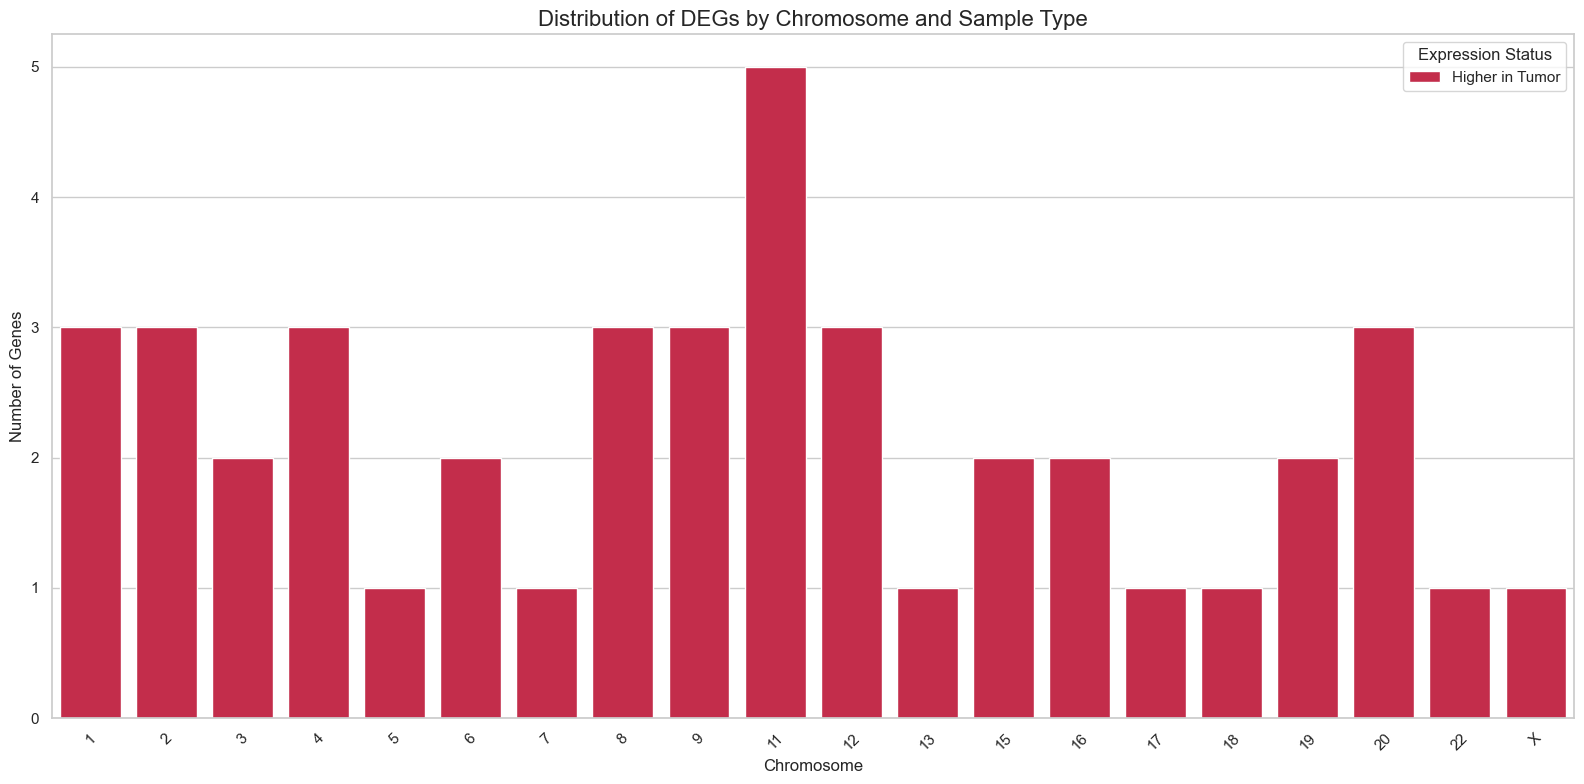

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Get a list of unique chromosome names
chromosomes = [c for c in degs_df['Chromosome'].unique() if pd.notna(c)]

def chromosome_sort_key(chrom):
    chrom = str(chrom) 
    if chrom.isdigit():
        return int(chrom)
    elif chrom.upper() == 'X':
        return 23
    elif chrom.upper() == 'Y':
        return 24
    else:
        return 25 

# Apply the custom sorting key
sorted_chromosomes = sorted(chromosomes, key=chromosome_sort_key)

# Create the plot
plt.figure(figsize=(16, 8))
ax = sns.countplot(
    data=degs_df,
    x='Chromosome',
    hue='Expression_Status', 
    order=sorted_chromosomes, 
    palette={'Higher in Tumor': 'crimson', 'Higher in Normal': 'royalblue'}
)

ax.set_title('Distribution of DEGs by Chromosome and Sample Type', fontsize=16)
ax.set_xlabel('Chromosome', fontsize=12)
ax.set_ylabel('Number of Genes', fontsize=12)
ax.legend(title='Expression Status')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

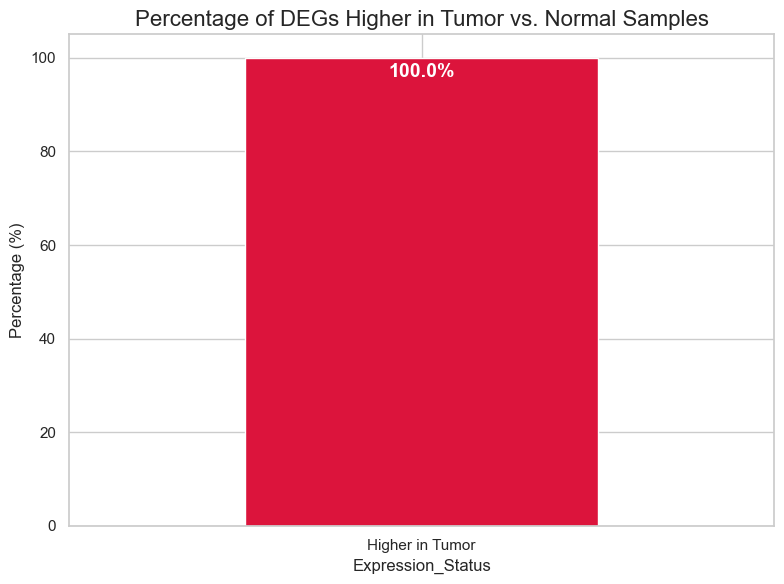

In [ ]:
# Calculate the percentage of up-regulated and down-regulated genes
status_counts = degs_df['Expression_Status'].value_counts(normalize=True) * 100

plt.figure(figsize=(8, 6))

# Create the bar plot
ax = status_counts.plot(
    kind='bar',
    color=['crimson', 'royalblue'],
    rot=0
)

ax.set_title('Percentage of DEGs Higher in Tumor vs. Normal Samples', fontsize=16)
ax.set_ylabel('Percentage (%)', fontsize=12)

# Add percentage labels 
for i, (label, value) in enumerate(status_counts.items()):
    ax.text(i, value - 5, f'{value:.1f}%', ha='center', va='bottom', color='white', fontsize=14, weight='bold')

plt.tight_layout()
plt.show()

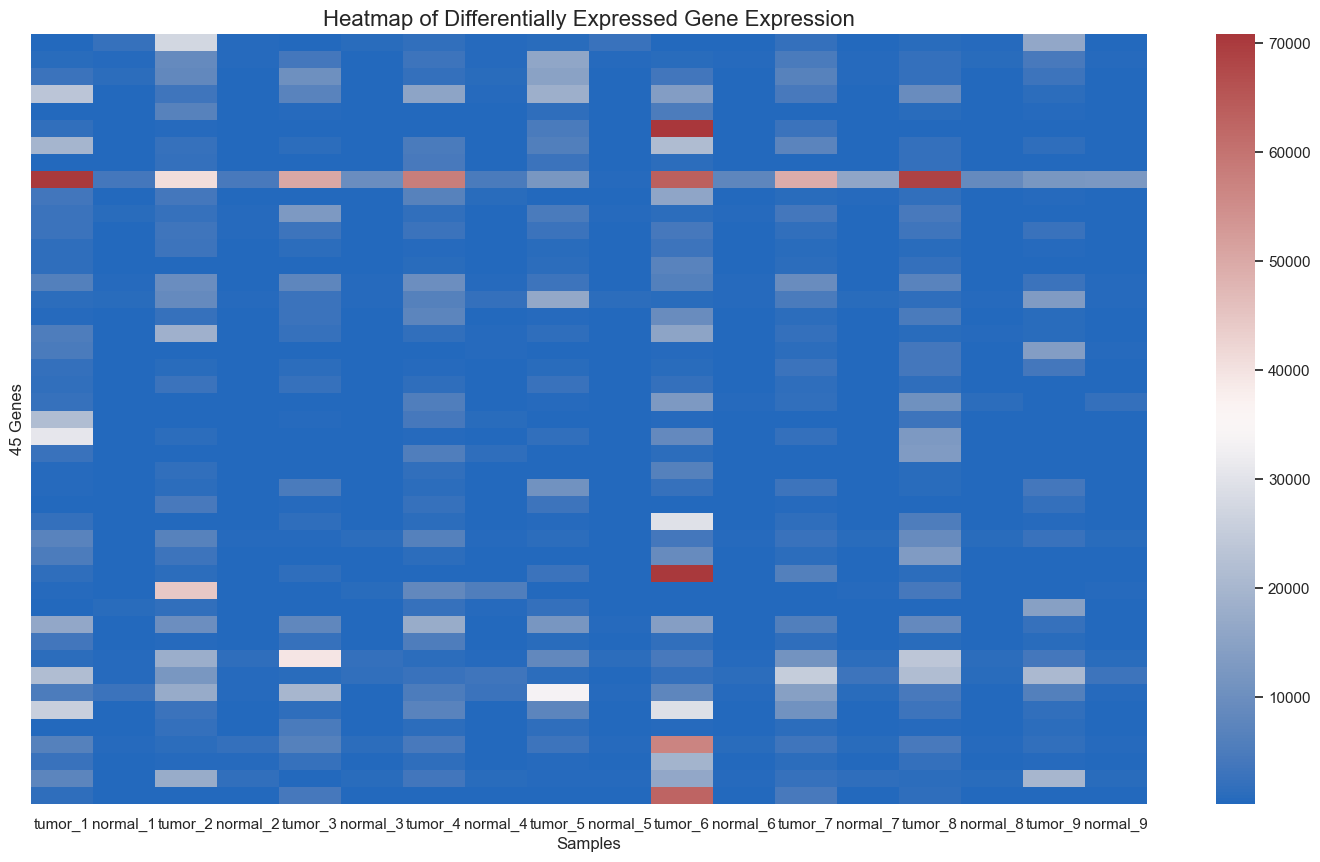

In [ ]:

# Get the expression data for only the significant genes
degs_expression_data = renamed_gene_expr_df.loc[degs_df['Probe_ID']]

plt.figure(figsize=(18, 10))

# Create the heatmap
sns.heatmap(
    degs_expression_data,
    cmap='vlag', # A red-white-blue colormap for showing deviation
    yticklabels=False 
)

plt.title('Heatmap of Differentially Expressed Gene Expression', fontsize=16)
plt.xlabel('Samples', fontsize=12)
plt.ylabel(f'{len(degs_df)} Genes', fontsize=12)
plt.show()

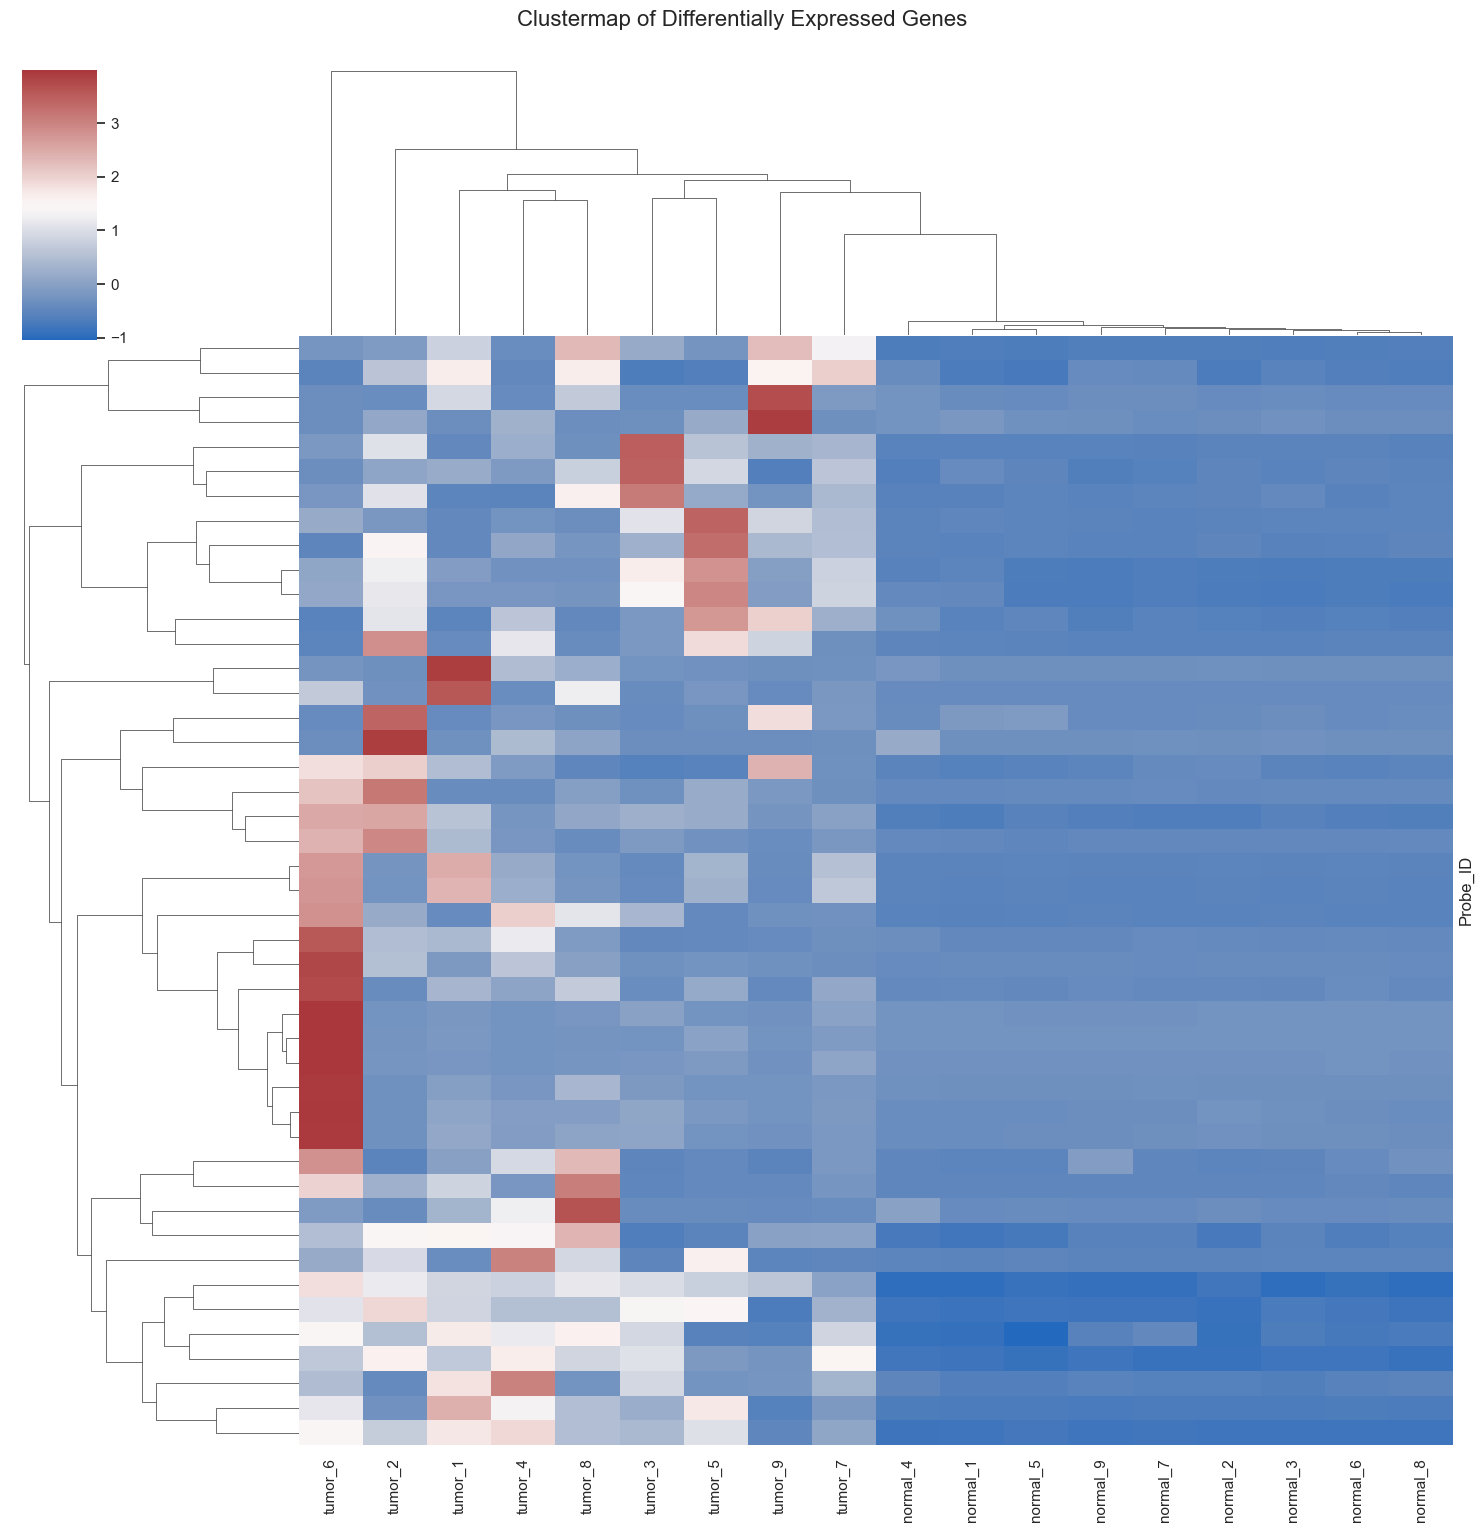

In [ ]:
# A clustermap clustering rows (genes) and columns (samples)
sns.clustermap(
    degs_expression_data,
    z_score=0,  # Standardize by row (gene)
    cmap='vlag',
    yticklabels=False,
    figsize=(15, 15)
)

plt.suptitle('Clustermap of Differentially Expressed Genes', y=1.02, fontsize=16)
plt.show()

Our analysis identified 45 genes that show significantly higher activity in tumor tissues compared to normal tissues. As shown in the bar chart, all 45 genes were more active in tumors, with none showing higher activity in normal samples. The clustermap further confirms this pattern—these genes clearly separate tumor and normal samples into two distinct groups, highlighting a strong molecular signature of tumor tissue.